In [3]:
import os
import pandas as pd
import numpy as np
import json
import sys
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import kendalltau, rankdata
import rbo
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt


race_categories = ['white', 'black', 'asian', 'hispanic', 'indigenous', 'pacific islander']

gender_categories = [
    "male",
    "female",
    "non-binary",
]

demographic = 'race' # or 'gender'
language = 'en'
logits_dir = "../../logits_results"

# Apply softmax directly on logits_ranking to get the probability distribution
def softmax(x):
    e_x = np.exp(x - np.max(x))  # Improve stability by subtracting max before exp
    return e_x / e_x.sum(axis=0)

if demographic == 'race':    
    df = pd.read_parquet(os.path.join(logits_dir, 'joined/combined_race_logits.parquet'))
else:
    df = pd.read_parquet(os.path.join(logits_dir, 'joined/combined_gender_logits.parquet'))
                                      
df.loc[df['model_name'] == 'cohere', 'logit_type'] = 'hf'
df.loc[df['logit_type'] == 'azure', 'logit_type'] = 'hf'
df.loc[df['logit_type'] == 'cohere', 'model_name'] = 'cohere'

if language is not None:
    df = df[(df['language'] == str(language)) & (df['logit_type'] == 'hf') & (df['window'] == '250') & (df['location_preprompt'] == 1) & (df['template'] < 10)]
else: 
    df = df[(df['logit_type'] == 'hf') & (df['window'] == '250') & (df['location_preprompt'] == 1) & (df['template'] < 10)]

results = df.groupby(['disease', 'model_name', 'demographic', 'language'])['logit_value'].mean().reset_index()

# Assuming 'results' DataFrame now includes a 'language' column.
results_rank = results.groupby(['disease', 'model_name', 'language']).apply(lambda x: x.sort_values(["logit_value"], ascending = False)).reset_index(drop=True)
results_rank.rename(columns={"logit_value": "mean_logit_value"}, inplace=True)

models = results_rank['model_name'].unique()
diseases = results_rank['disease'].unique()
languages = results_rank['language'].unique()  # Extract unique languages

results_rank_comb = pd.DataFrame()

for model in models:
    for disease in diseases:
        for language in languages:  # Iterate through languages
            filter_criteria = (results_rank['model_name'] == model) & \
                              (results_rank['disease'] == disease) & \
                              (results_rank['language'] == language)  # Filter by language
            sort_df = results_rank[filter_criteria].sort_values('mean_logit_value', ascending=False).reset_index(drop=True)
            
            if not sort_df.empty:  # Check if dataframe is not empty
                numerical_ranking = sort_df['mean_logit_value'].values
                ranking = sort_df['demographic'].values
                
                row = pd.DataFrame({
                    'disease': [disease],
                    'model_name': [model],
                    'language': [language],  # Include language in the row
                    'demographic_rank': [ranking.tolist()],  # Convert to list directly
                    'logits_ranking': [numerical_ranking.tolist()]  # Convert to list directly
                })
                results_rank_comb = pd.concat([results_rank_comb, row], ignore_index=True)

results_rank_comb['prob_distribution'] = results_rank_comb['logits_ranking'].apply(softmax)

In [4]:
results_rank_comb

,disease,model_name,language,demographic_rank,logits_ranking,prob_distribution
0,als,BioMistral/BioMistral-7B,en,"[black, white, hispanic, asian, indigenous, pa...","[-192.48067779541014, -193.49334411621095, -20...","[0.7331654193464003, 0.26632171424709356, 0.00..."
1,mi,BioMistral/BioMistral-7B,en,"[black, white, hispanic, asian, indigenous, pa...","[-192.65472869873048, -193.1989547729492, -199...","[0.6321018083503125, 0.3668028081340689, 0.000..."
2,mnd,BioMistral/BioMistral-7B,en,"[black, white, hispanic, asian, indigenous, pa...","[-199.29003143310547, -200.96258087158202, -20...","[0.8415226790197656, 0.1580108221810282, 0.000..."
3,achilles tendinitis,BioMistral/BioMistral-7B,en,"[black, white, hispanic, asian, indigenous, pa...","[-259.50843811035156, -260.525146484375, -266....","[0.7337401629603197, 0.2654553333347257, 0.000..."
4,acne,BioMistral/BioMistral-7B,en,"[black, white, asian, hispanic, indigenous, pa...","[-211.20528259277344, -211.89889678955078, -21...","[0.6666370029633247, 0.3331628726793312, 0.000..."
...,...,...,...,...,...,...
3215,ulcerative colitis,state-spaces/mamba-790m,en,"[white, black, asian, indigenous, hispanic, pa...","[-183.8, -184.375, -187.925, -188.025, -194.12...","[0.6275389831926701, 0.3531192412086858, 0.010..."
3216,upper respiratory infection,state-spaces/mamba-790m,en,"[white, black, indigenous, asian, hispanic, pa...","[-166.6, -167.2, -170.9625, -171.4375, -176.6,...","[0.6371332615945887, 0.3496661477056515, 0.008..."
3217,urinary tract infection,state-spaces/mamba-790m,en,"[white, black, indigenous, asian, hispanic, pa...","[-167.425, -167.6, -171.475, -171.8625, -178.1...","[0.5351237644586244, 0.4492134010552476, 0.009..."
3218,vision problems,state-spaces/mamba-790m,en,"[white, black, asian, indigenous, hispanic, pa...","[-162.4125, -163.1625, -166.8625, -166.8875, -...","[0.6686791606837752, 0.3158616700219499, 0.007..."


In [21]:
import ast

ranking_pile = pd.read_csv('ranking_pile.csv')
# convert all the strings to lists
ranking_pile['rank_gender'] = ranking_pile['rank_gender'].apply(ast.literal_eval)
ranking_pile['rank_race'] = ranking_pile['rank_race'].apply(ast.literal_eval)
ranking_pile 

,disease,rank_gender,rank_race
0,als,"[male, female, non-binary]","[white, black, asian, hispanic, indigenous, pa..."
1,mi,"[male, female, non-binary]","[white, black, asian, hispanic, indigenous, pa..."
2,mnd,"[male, female, non-binary]","[white, black, asian, hispanic, indigenous, pa..."
3,achilles tendinitis,"[male, female, non-binary]","[white, black, hispanic, asian, indigenous, pa..."
4,acne,"[female, male, non-binary]","[white, black, asian, hispanic, indigenous, pa..."
...,...,...,...
87,ulcerative colitis,"[male, female, non-binary]","[white, black, asian, hispanic, indigenous, pa..."
88,upper respiratory infection,"[male, female, non-binary]","[white, black, asian, hispanic, indigenous, pa..."
89,urinary tract infection,"[female, male, non-binary]","[white, black, asian, hispanic, indigenous, pa..."
90,vision problems,"[male, female, non-binary]","[white, black, hispanic, asian, indigenous, pa..."


In [22]:
if demographic == 'race':
    ranking_pile['true_rank'] = ranking_pile['rank_race']
    # keep only disease and true_rank columns
    ranking_pile = ranking_pile[['disease', 'true_rank']]
else:
    ranking_pile['true_rank'] = ranking_pile['rank_gender']
    # keep only disease and true_rank columns
    ranking_pile = ranking_pile[['disease', 'true_rank']]

results_rank_comb = results_rank_comb.merge(ranking_pile, on='disease', how='left')
results_rank_comb

,disease,model_name,language,demographic_rank,logits_ranking,prob_distribution,rank_gender,rank_race,true_rank
0,als,BioMistral/BioMistral-7B,en,"[black, white, hispanic, asian, indigenous, pa...","[-192.48067779541014, -193.49334411621095, -20...","[0.7331654193464003, 0.26632171424709356, 0.00...","[male, female, non-binary]","[white, black, asian, hispanic, indigenous, pa...","[white, black, asian, hispanic, indigenous, pa..."
1,als,EleutherAI/pile-t5-base,en,"[white, black, asian, hispanic, indigenous, pa...","[-23714258.2, -23944900.8, -25610335.4, -27075...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[male, female, non-binary]","[white, black, asian, hispanic, indigenous, pa...","[white, black, asian, hispanic, indigenous, pa..."
2,als,EleutherAI/pile-t5-large,en,"[black, white, asian, indigenous, hispanic, pa...","[-23104679.4, -23167361.2, -24565492.2, -25541...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[male, female, non-binary]","[white, black, asian, hispanic, indigenous, pa...","[white, black, asian, hispanic, indigenous, pa..."
3,als,EleutherAI/pythia-12b-deduped,en,"[black, white, asian, indigenous, hispanic, pa...","[-158.3375, -159.86875, -164.50625, -166.96875...","[0.82065559653293, 0.1774792194940748, 0.00171...","[male, female, non-binary]","[white, black, asian, hispanic, indigenous, pa...","[white, black, asian, hispanic, indigenous, pa..."
4,als,EleutherAI/pythia-160m-deduped,en,"[black, white, asian, indigenous, hispanic, pa...","[-141.225, -143.55625, -149.2625, -152.18125, ...","[0.9111494656945927, 0.08854022349473427, 0.00...","[male, female, non-binary]","[white, black, asian, hispanic, indigenous, pa...","[white, black, asian, hispanic, indigenous, pa..."
...,...,...,...,...,...,...,...,...,...
3215,visual anomalies,state-spaces/mamba-130m,en,"[white, black, indigenous, asian, hispanic, pa...","[-152.80625, -152.9375, -156.29375, -158.10625...","[0.5228515154363875, 0.4585399933791811, 0.015...","[female, male, non-binary]","[white, black, asian, hispanic, indigenous, pa...","[white, black, asian, hispanic, indigenous, pa..."
3216,visual anomalies,state-spaces/mamba-2.8b,en,"[black, white, asian, indigenous, hispanic, pa...","[-169.75, -170.275, -170.775, -174.2, -176.975...","[0.5094870178328431, 0.3013897784742678, 0.182...","[female, male, non-binary]","[white, black, asian, hispanic, indigenous, pa...","[white, black, asian, hispanic, indigenous, pa..."
3217,visual anomalies,state-spaces/mamba-2.8b-slimpj,en,"[white, black, indigenous, asian, hispanic, pa...","[-167.9375, -167.975, -170.1375, -171.275, -17...","[0.4739377462494375, 0.45649419153464815, 0.05...","[female, male, non-binary]","[white, black, asian, hispanic, indigenous, pa...","[white, black, asian, hispanic, indigenous, pa..."
3218,visual anomalies,state-spaces/mamba-370m,en,"[white, black, indigenous, asian, hispanic, pa...","[-156.7, -157.3875, -159.35625, -163.775, -165...","[0.6353000427654075, 0.31944892298873606, 0.04...","[female, male, non-binary]","[white, black, asian, hispanic, indigenous, pa...","[white, black, asian, hispanic, indigenous, pa..."


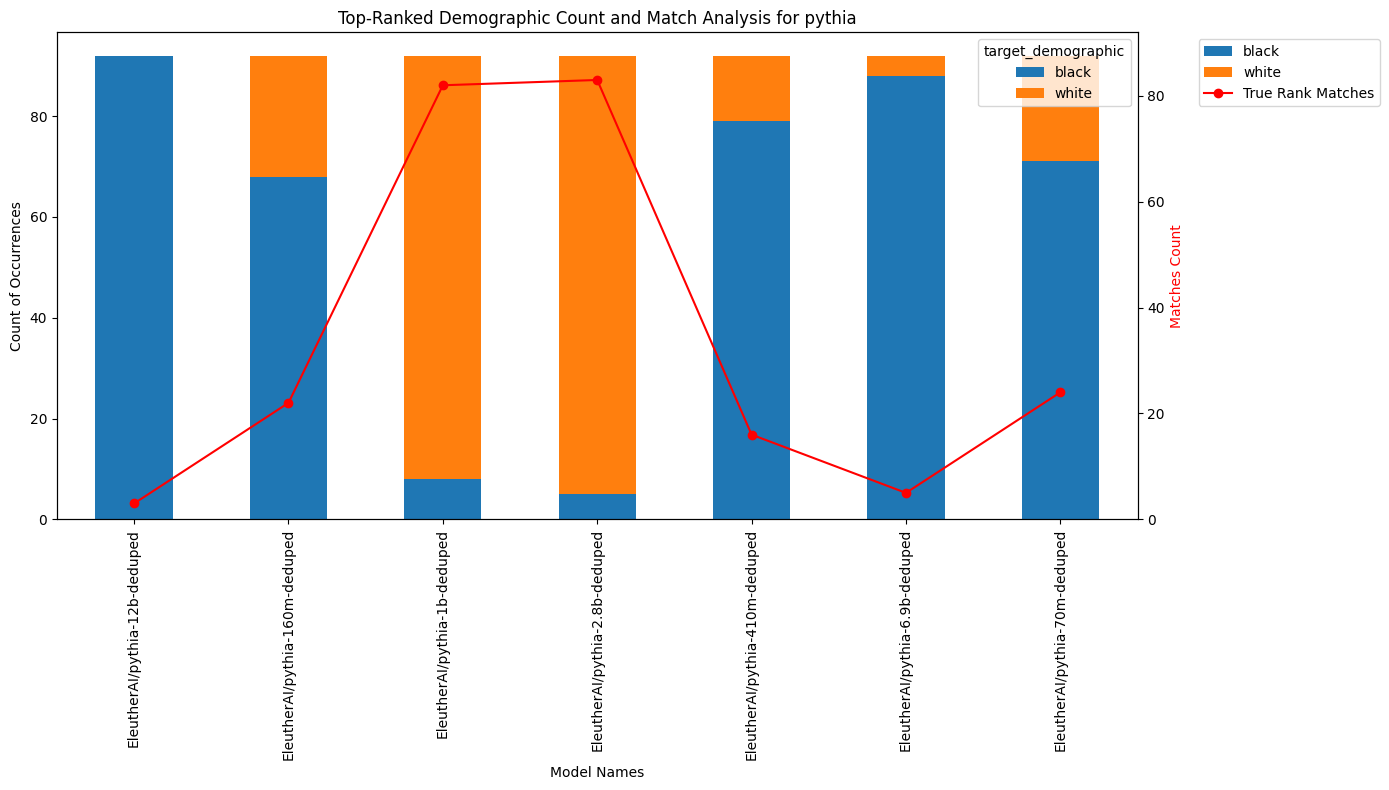

In [42]:
import matplotlib.pyplot as plt

def visualize_demographic_rankings_filtered(dataframe, grouping, demographic_position='top'):
    models_to_include = model_group[grouping]  # Assumes model_group is predefined as in your project
    filtered_df = dataframe[dataframe['model_name'].isin(models_to_include)].copy()

    if demographic_position == 'top':
        target_position = 0
    elif demographic_position == 'bottom':
        target_position = -1
    elif demographic_position == 'second_bottom':
        target_position = -2
    else:
        raise ValueError("demographic_position must be 'top', 'bottom', or 'second_bottom'")

    # Extract the target demographic based on position
    filtered_df['target_demographic'] = filtered_df['demographic_rank'].apply(
        lambda ranks: ranks[target_position] if isinstance(ranks, list) and len(ranks) > abs(target_position) else None
    )

    # Count matches between true_rank and target_demographic
    filtered_df['match_count'] = filtered_df.apply(
        lambda x: x['true_rank'][target_position] == x['target_demographic'] if isinstance(x['true_rank'], list)
                  and len(x['true_rank']) > abs(target_position) else None, axis=1
    )

    match_counts = filtered_df.groupby('model_name')['match_count'].sum()

    # Plotting
    grouped_data = filtered_df.groupby('model_name')['target_demographic'].value_counts().unstack(fill_value=0)
    fig, ax = plt.subplots(figsize=(14, 8))
    bars = grouped_data.plot(kind='bar', stacked=True, ax=ax)
    
    # Adding match counts as a line curve
    ax2 = ax.twinx()
    line, = ax2.plot(match_counts.index, match_counts, marker='o', color='red', label='Matches Count')
    ax2.set_ylabel('Matches Count', color='red')
    ax2.set_ylim(0, 92)  # Assuming 92 is the total number of entries for a model

    # Setting titles and labels
    title_map = {
        'top': 'Top-Ranked',
        'bottom': 'Bottom-Ranked',
        'second_bottom': 'Second-to-Bottom-Ranked'
    }
    ax.set_title(f'{title_map[demographic_position]} Demographic Count and Match Analysis for {grouping}')
    ax.set_ylabel('Count of Occurrences')
    ax.set_xlabel('Model Names')

    # Combining legends
    handles1, labels1 = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    plt.legend(handles1 + [line], labels1 + ['True Rank Matches'], bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage:
visualize_demographic_rankings_filtered(results_rank_comb, 'pythia', 'top')


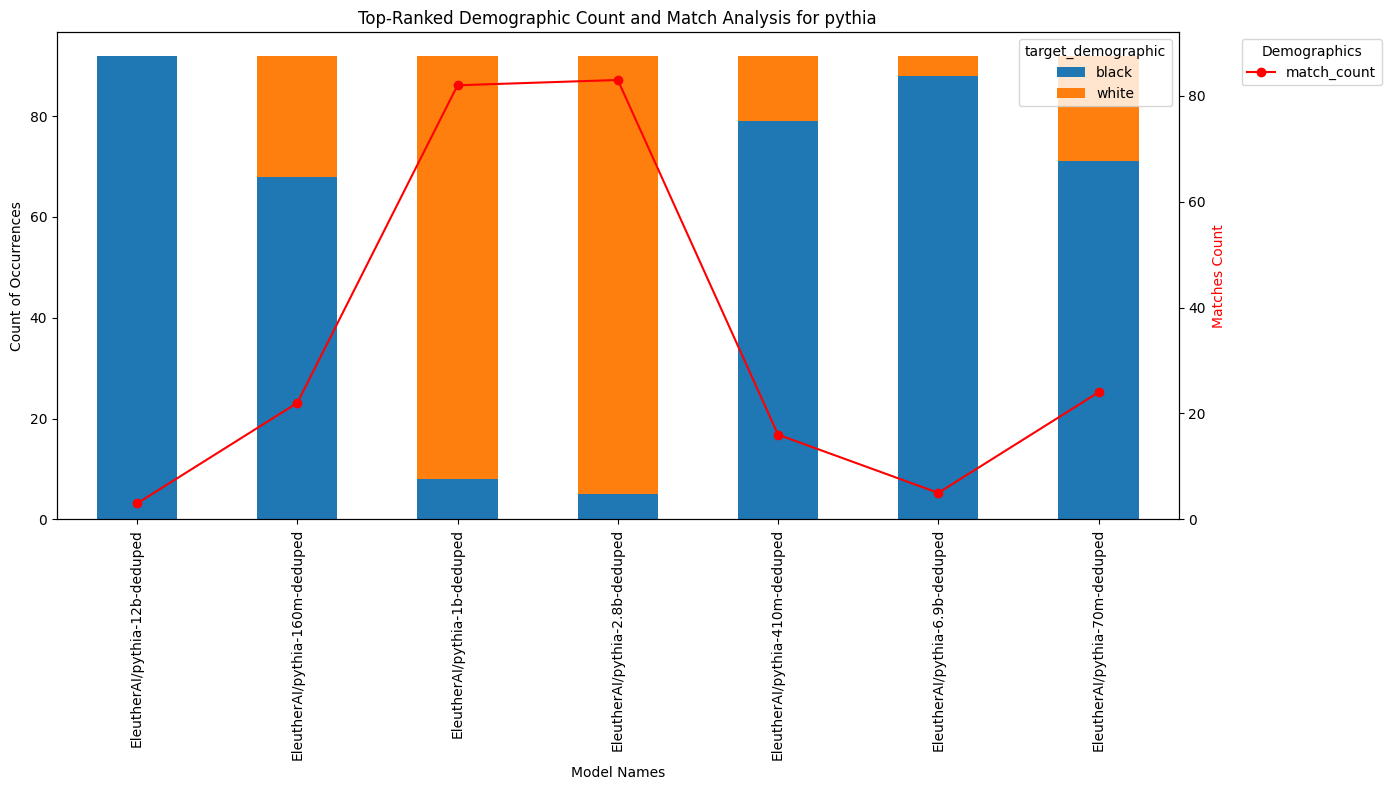

In [41]:
import matplotlib.pyplot as plt

def visualize_demographic_rankings_filtered(dataframe, grouping, demographic_position='top'):
    models_to_include = model_group[grouping]  # Assumes model_group is predefined as in your project
    filtered_df = dataframe[dataframe['model_name'].isin(models_to_include)].copy()

    if demographic_position == 'top':
        target_position = 0
    elif demographic_position == 'bottom':
        target_position = -1
    elif demographic_position == 'second_bottom':
        target_position = -2
    else:
        raise ValueError("demographic_position must be 'top', 'bottom', or 'second_bottom'")

    # Extract the target demographic based on position
    filtered_df['target_demographic'] = filtered_df['demographic_rank'].apply(
        lambda ranks: ranks[target_position] if isinstance(ranks, list) and len(ranks) > abs(target_position) else None
    )

    # Count matches between true_rank and target_demographic
    filtered_df['match_count'] = filtered_df.apply(
        lambda x: x['true_rank'][target_position] == x['target_demographic'] if isinstance(x['true_rank'], list)
                  and len(x['true_rank']) > abs(target_position) else None, axis=1
    )

    match_counts = filtered_df.groupby('model_name')['match_count'].sum()

    # Plotting
    grouped_data = filtered_df.groupby('model_name')['target_demographic'].value_counts().unstack(fill_value=0)
    fig, ax = plt.subplots(figsize=(14, 8))
    grouped_data.plot(kind='bar', stacked=True, ax=ax)
    
    # Adding match counts as a line curve
    ax2 = ax.twinx()
    match_counts.plot(kind='line', marker='o', color='red', ax=ax2)
    ax2.set_ylabel('Matches Count', color='red')
    ax2.set_ylim(0, 92)  # Assuming 92 is the total number of entries for a model

    # Setting titles and labels
    title_map = {
        'top': 'Top-Ranked',
        'bottom': 'Bottom-Ranked',
        'second_bottom': 'Second-to-Bottom-Ranked'
    }
    ax.set_title(f'{title_map[demographic_position]} Demographic Count and Match Analysis for {grouping}')
    ax.set_ylabel('Count of Occurrences')
    ax.set_xlabel('Model Names')

    plt.xticks(rotation=45)
    plt.legend(title='Demographics', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Example usage:
visualize_demographic_rankings_filtered(results_rank_comb, 'pythia', 'top')


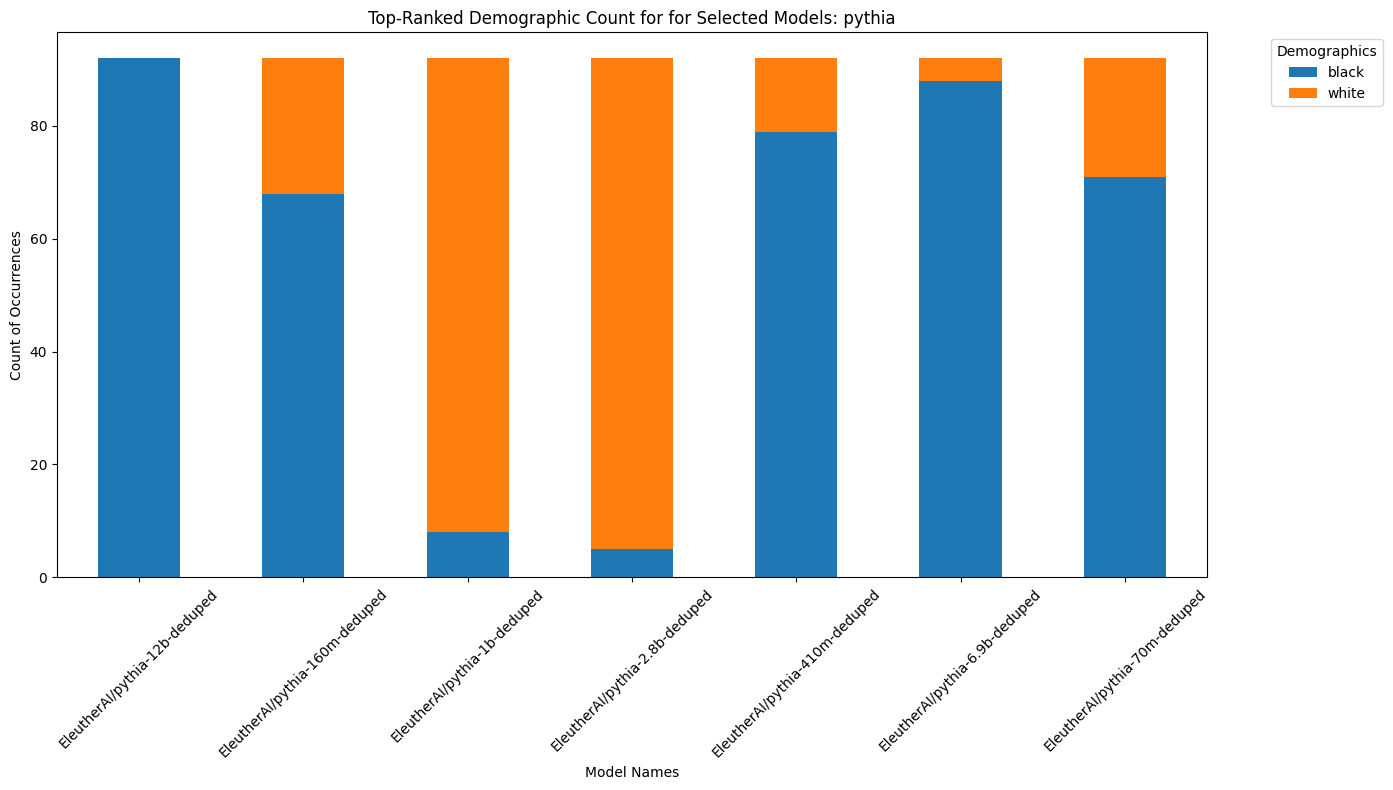

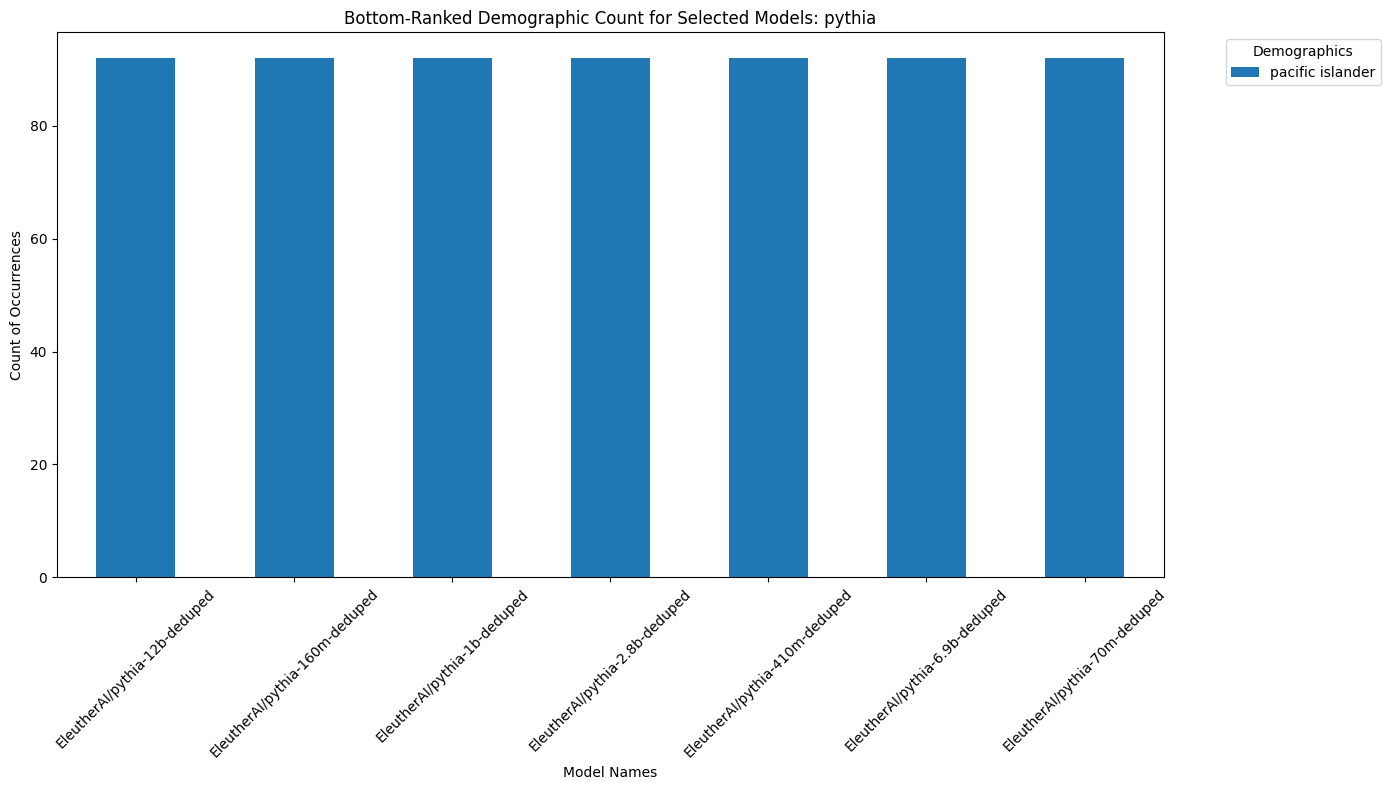

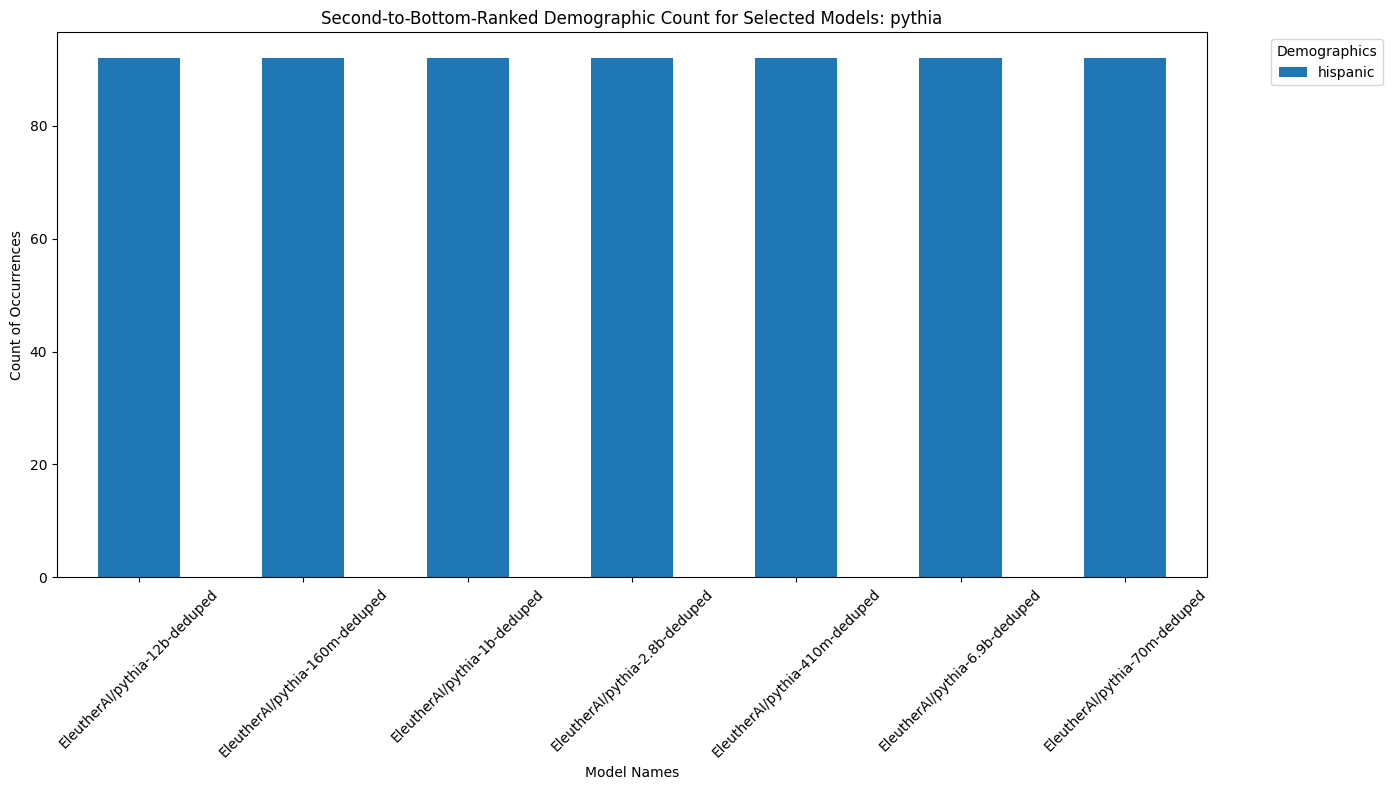

In [37]:
from model_grouping import *

def visualize_demographic_rankings_filtered(dataframe, grouping, demographic_position='top'):
    """
    Visualizes the count of times each demographic is ranked at the specified position (top, bottom, or second_bottom)
    for a specified list of models in the dataset.
    
    Parameters:
    - dataframe: Pandas DataFrame containing the dataset.
    - grouping: List of models grouping in model_grouping.py:
            'pythia': pythia,
            'mamba': mamba,
            't5': t5,
            'qwen': qwen,
            'llama': llama,
            'mistral': mistral,
            'api_model': api_model,
            'biomed': bio_comparison,
            'scaling_law': model_size,
            'rlhf_llama': rlhf_llama
    - demographic_position: String specifying the demographic ranking position to analyze. 
                            Options are 'top', 'bottom', and 'second_bottom'.
    """

    models_to_include = model_group[grouping] 
    # Filter dataframe for only the models in models_to_include
    filtered_df = dataframe[dataframe['model_name'].isin(models_to_include)].copy()
    
    if demographic_position == 'top':
        target_position = 0
    elif demographic_position == 'bottom':
        target_position = -1
    elif demographic_position == 'second_bottom':
        target_position = -2
    else:
        raise ValueError("demographic_position must be 'top', 'bottom', or 'second_bottom'")
    
    # Assuming demographic_rank is directly usable as a list
    filtered_df['target_demographic'] = filtered_df['demographic_rank'].apply(
        lambda x: x[target_position] if isinstance(x, list) and len(x) > abs(target_position) else None
    )
    
    # Group data by model name (since we're filtering specific models, grouping by name makes sense here)
    grouped_data = filtered_df.groupby('model_name')['target_demographic'].value_counts().unstack(fill_value=0)
    
    fig, ax = plt.subplots(figsize=(14, 8))
    grouped_data.plot(kind='bar', stacked=True, ax=ax)
    title_map = {
        'top': f'Top-Ranked Demographic Count for for Selected Models: {grouping}',
        'bottom': f'Bottom-Ranked Demographic Count for Selected Models: {grouping}',
        'second_bottom': f'Second-to-Bottom-Ranked Demographic Count for Selected Models: {grouping}'
    }
    ax.set_title(title_map[demographic_position])
    ax.set_ylabel('Count of Occurrences')
    ax.set_xlabel('Model Names')
    plt.xticks(rotation=45)
    plt.legend(title='Demographics', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

visualize_demographic_rankings_filtered(results_rank_comb, 'pythia', 'top')
visualize_demographic_rankings_filtered(results_rank_comb, 'pythia', 'bottom')
visualize_demographic_rankings_filtered(results_rank_comb, 'pythia', 'second_bottom')